In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings

In [5]:
train = pd.read_csv('../data/rsna-2024-lumbar-spine-degenerative-classification/train.csv')

In [6]:
print(len(train))

1975


In [7]:
train.columns

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

In [8]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


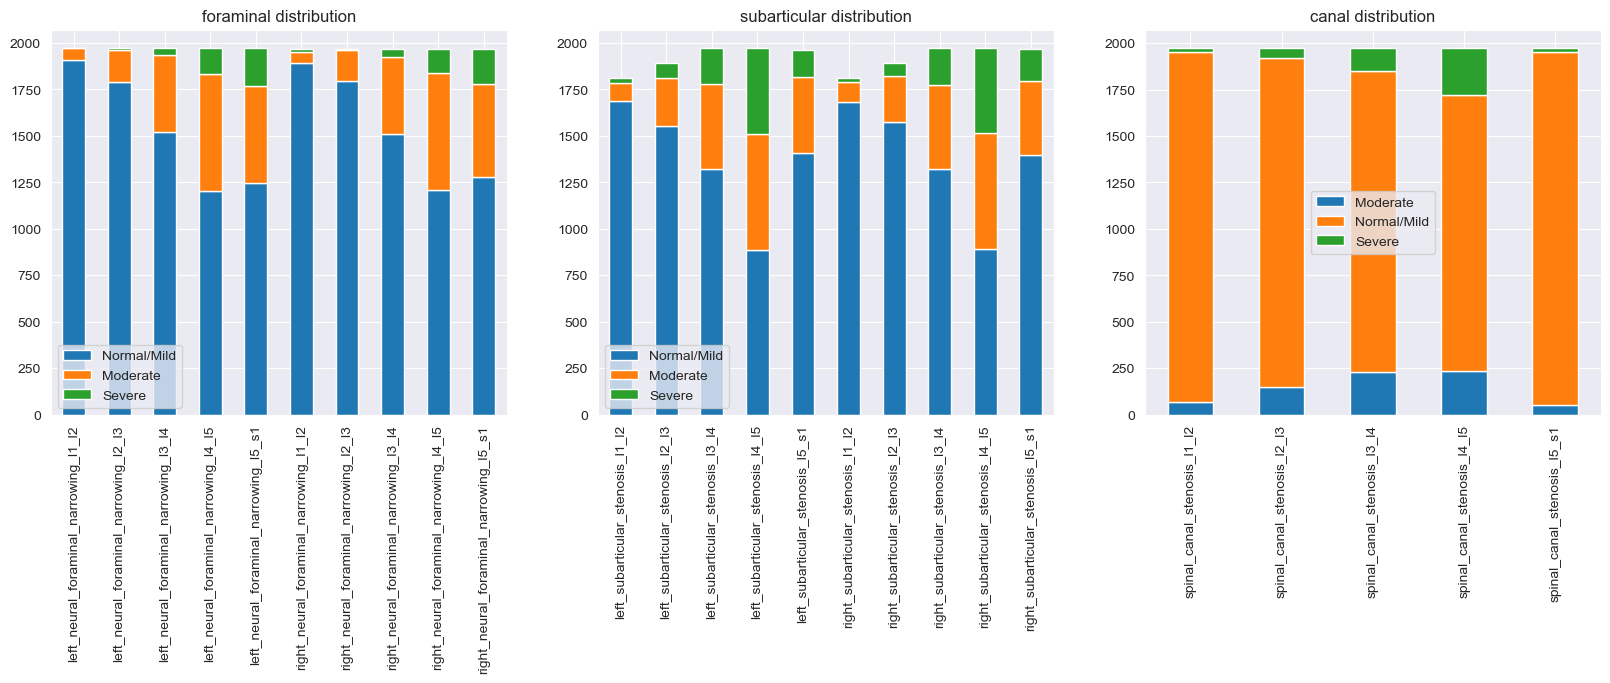

In [9]:
figure, axis = plt.subplots(1, 3, figsize=(20, 5))
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    diagnosis = list(filter(lambda x: x.find(d) > -1, train.columns))
    dff = train[diagnosis]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{d} distribution')

In [10]:
# List out all of the Studies we have on patients.
part_1 = os.listdir('../data/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))

In [11]:
df_meta_f = pd.read_csv('../data/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [12]:
p1 = [(x, f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}") for x in part_1]
meta_obj = {p[0]: {'folder_path': p[1],
                   'SeriesInstanceUIDs': []
                   }
            for p in p1}

In [13]:
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1,
               os.listdir(meta_obj[m]['folder_path'])
               )
    )

In [14]:
# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) &
                          (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

100%|██████████| 1975/1975 [00:00<00:00, 2090.02it/s]


In [15]:
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/213335325',
 'SeriesInstanceUIDs': ['1062372272', '858832151', '1153454550'],
 'SeriesDescriptions': ['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']}

In [16]:
patient = train.iloc[1]

In [17]:
ptobj = meta_obj[str(patient['study_id'])]

In [18]:
print(ptobj)

{'folder_path': '../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740', 'SeriesInstanceUIDs': ['3486248476', '3666319702', '3201256954'], 'SeriesDescriptions': ['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']}


In [19]:
# Get data into the format
"""
im_list_dcm = {
    '{SeriesInstanceUID}': {
        'images': [
            {'SOPInstanceUID': ...,
             'dicom': PyDicom object
            },
            ...,
        ],
        'description': # SeriesDescription
    },
    ...
}
"""
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    for j in sorted(images, key=lambda x: int(x.split('\\')[-1].split("/")[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('\\')[-1].split("/")[-1].replace('.dcm', ''),
            'dicom': pydicom.dcmread(j)})

In [20]:
# Function to display images
def display_images(images, title, max_images_per_row=4):
    # Calculate the number of rows needed
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Ceiling division

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5, 1.5 * num_rows))

    # Flatten axes array for easier looping if there are multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable for consistency

    # Plot each image
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')  # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')  # Hide axes

    # Turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()

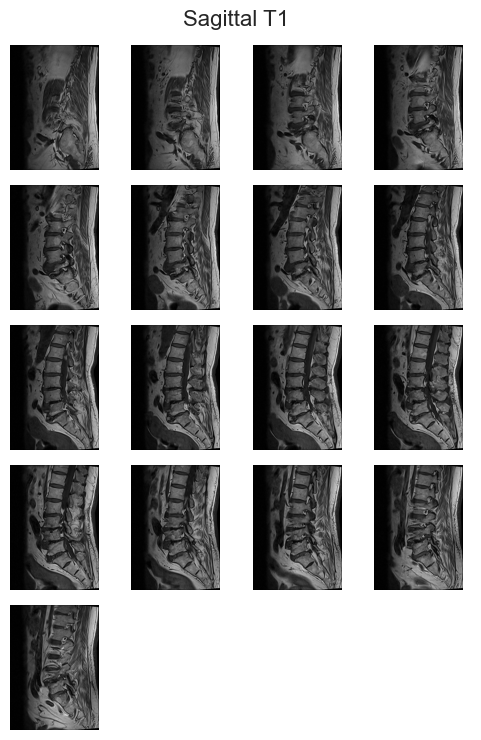

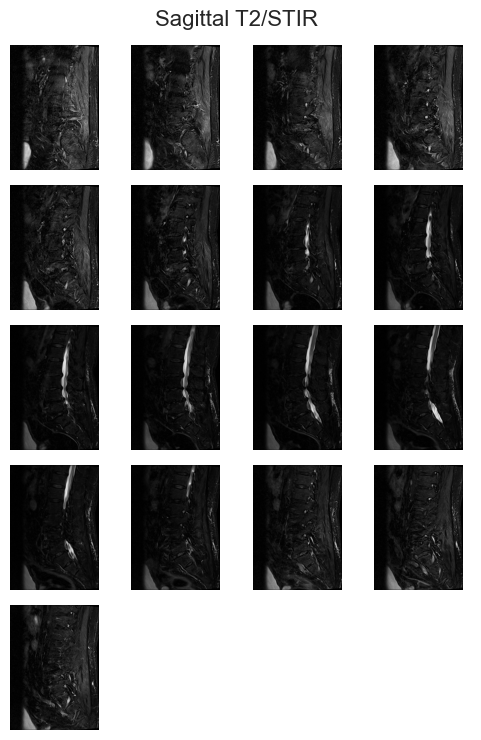

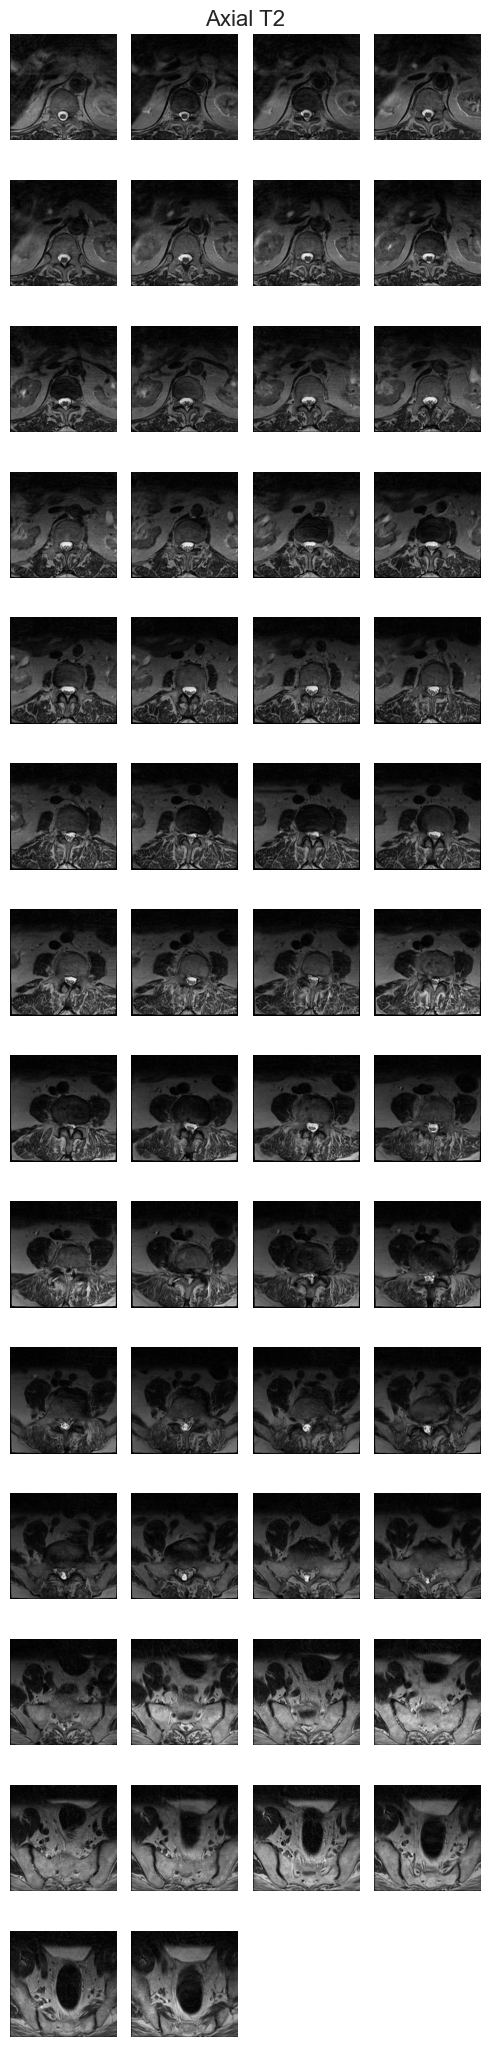

In [21]:
for i in im_list_dcm:
    display_images([x['dicom'].pixel_array for x in im_list_dcm[i]['images']],
                   im_list_dcm[i]['description'])

In [22]:
df_coor = pd.read_csv('../data/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

In [23]:
df_coor.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [24]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 10
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = i['dicom'].pixel_array
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)

    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(IMG_with_circle)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(title)
    plt.show()

In [25]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]

Only showing severe cases for this patient


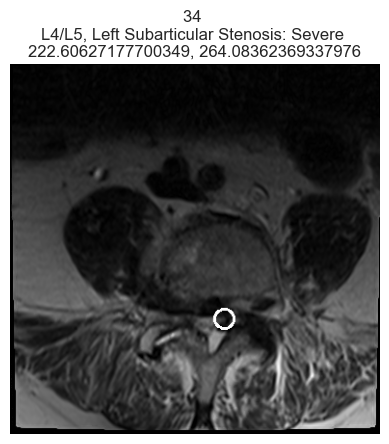

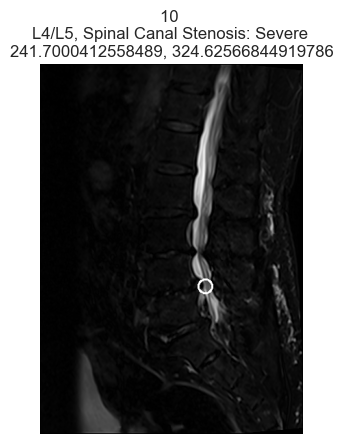

In [26]:
print("Only showing severe cases for this patient")
for idc, c in coor_entries.iterrows():
    for i in im_list_dcm[str(c['series_id'])]['images']:
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                patient_severity = patient[
                    f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"
                ]
            except Exception as e:
                patient_severity = "unknown severity"
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)

In [27]:
im_list_dcm.keys()

dict_keys(['3486248476', '3666319702', '3201256954'])

In [28]:
im_list_dcm['3486248476']

{'images': [{'SOPInstanceUID': '1',
   'dicom': Dataset.file_meta -------------------------------
   (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
   (0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
   (0002, 0003) Media Storage SOP Instance UID      UI: 4646740.1.1
   (0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
   (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
   (0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
   -------------------------------------------------
   (0008, 0018) SOP Instance UID                    UI: 4646740.1.1
   (0008, 0023) Content Date                        DA: '20240503'
   (0008, 0033) Content Time                        TM: '223734.008099'
   (0008, 103e) Series Description                  LO: ''
   (0010, 0020) Patient ID                          LO: '4646740'
   (0018, 0050) Slice Thickness                     DS: '3.0'
   (0018, 0088) Spacin

In [29]:
t1_images = np.array([x['dicom'].pixel_array for x in im_list_dcm['3486248476']['images']])
t1_images.shape

(17, 540, 384)

In [30]:
files = glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/11340341/1224932122/*")
files = [pydicom.dcmread(fname) for fname in files]
slices = []

skipcount = 0

for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d


skipped, no SliceLocation: 0


In [31]:
img3d[::4, ::4, :].shape

(80, 80, 45)

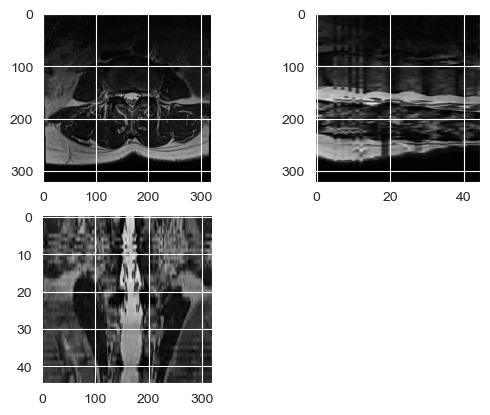

In [32]:
# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1] / ps[0]
sag_aspect = ps[1] / ss
cor_aspect = ss / ps[0]


def show_mid_slices(img3d):
    img_shape = img3d.shape

    a1 = plt.subplot(2, 2, 1)
    plt.imshow(img3d[:, :, img_shape[2] // 2], cmap="gray")
    a1.set_aspect(ax_aspect)

    a2 = plt.subplot(2, 2, 2)
    plt.imshow(img3d[:, img_shape[1] // 2, :], cmap="gray")
    a2.set_aspect(sag_aspect)

    a3 = plt.subplot(2, 2, 3)
    plt.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="gray")
    a3.set_aspect(cor_aspect)

    plt.show()


show_mid_slices(img3d)

In [33]:
files = glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/11340341/1224932122/*")
files = sorted(files, key=lambda x: int(x.split('\\')[-1].split("/")[-1].split('.')[0]))
slices = [pydicom.dcmread(fname) for fname in files]

img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

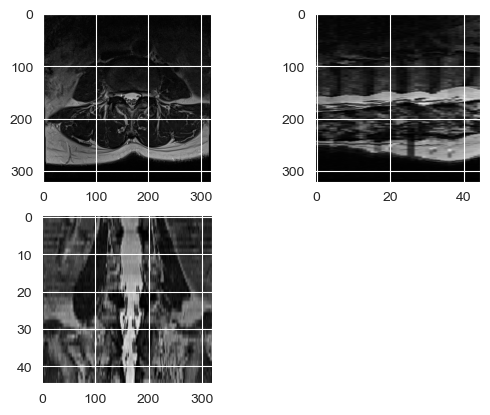

In [34]:
show_mid_slices(img3d)

In [35]:
ds = pydicom.dcmread("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/3486248476/9.dcm")

# get the pixel information into a numpy array
data = ds.pixel_array
print('The image has {} x {} voxels'.format(data.shape[0],
                                            data.shape[1]))

The image has 540 x 384 voxels


In [36]:
ds = pydicom.dcmread(
    "../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/3486248476/12.dcm")
ds.SliceLocation

'-0.353442'

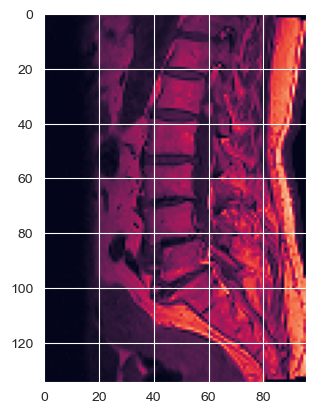

In [37]:
plt.imshow(data[::4, ::4])

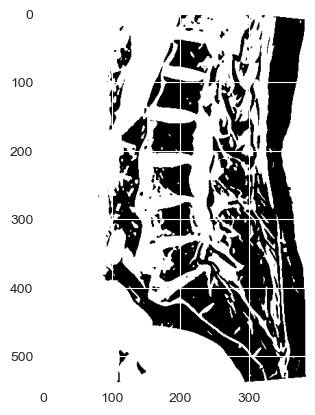

In [38]:
import cv2

ret, thresh = cv2.threshold(data, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

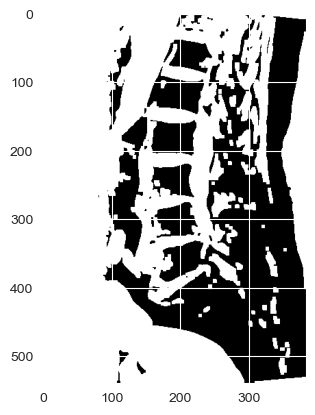

In [39]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(opening, cmap='gray')

In [40]:
opening

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint16)

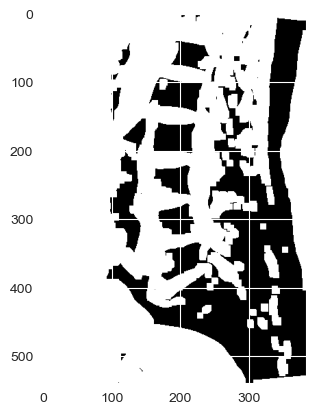

In [41]:
sure_bg = cv2.dilate(opening, kernel, iterations=2)

plt.imshow(sure_bg, cmap='gray')

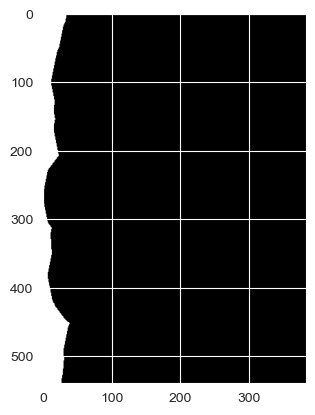

In [42]:
dist_transform = cv2.distanceTransform(np.array(opening, dtype=np.uint8), cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

plt.imshow(sure_fg, cmap='gray')

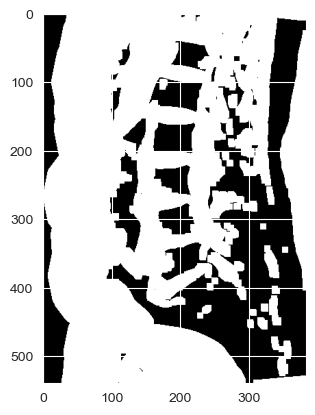

In [43]:
unknown = cv2.subtract(np.array(sure_bg, dtype=np.uint8), np.array(sure_fg, dtype=np.uint8))

plt.imshow(unknown, cmap='gray')

In [44]:
from rsna_dataloader import *

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

training_data = training_data.dropna()
training_data = training_data.groupby("study_id").filter(lambda x: len(x) != 75)

testset = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data)

In [45]:
testset[0][0][0].shape

RuntimeError: stack expects each tensor to be equal size, but got [512, 512, 19] at entry 0 and [512, 512, 36] at entry 1

In [49]:
def show_mid_slices(img3d):
    img_shape = img3d.shape

    a1 = plt.subplot(2, 2, 1)
    plt.imshow(img3d[:, :, img_shape[2] // 2], cmap="gray")

    a2 = plt.subplot(2, 2, 2)
    plt.imshow(img3d[:, img_shape[1] // 2, :], cmap="gray")

    a3 = plt.subplot(2, 2, 3)
    plt.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="gray")

    plt.show()


In [ ]:
show_mid_slices(testset[0][0][0])

In [ ]:
show_mid_slices(testset[0][0][1])

In [ ]:
show_mid_slices(testset[0][0][2])

In [ ]:
testset_2 = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data,
                                data_type=SeriesDataType.CUBE_3D_DOWNSAMPLED_PADDED, transform_2d=A.Resize(128, 128))
testset_2[0][0][0].shape

In [ ]:
show_mid_slices(testset_2[0][0][0])

In [ ]:
show_mid_slices(testset_2[0][0][1])

In [ ]:
show_mid_slices(testset_2[0][0][2])


In [ ]:
testset_3 = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data,
                                data_type=SeriesDataType.CUBE_3D_RESIZED_PADDED, transform_2d=A.Resize(128, 128))
testset_3[0][0][0].shape

In [ ]:
show_mid_slices(testset_3[0][0][0])

In [ ]:
show_mid_slices(testset_3[0][0][1])

In [ ]:
show_mid_slices(testset_3[0][0][2])

In [ ]:
transform_2d = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=0.5, std=0.5),
])

# transform_3d_train = V.Compose([
#     V.RotateAroundAxis3d(rotation_limit=math.pi / 2, axis=(1, 0, 0), p=CONFIG["aug_prob"]),
#     V.RotateAroundAxis3d(rotation_limit=math.pi / 2, axis=(0, 1, 0), p=CONFIG["aug_prob"]),
#     V.RotateAroundAxis3d(rotation_limit=math.pi / 2, axis=(0, 0, 1), p=CONFIG["aug_prob"]),
#     V.RandomMove3d(x_min=-12, y_min=-12, z_min=-12,
#                    x_max=12, y_max=12, z_max=12,
#                    p=CONFIG["aug_prob"]),
# ])


In [ ]:
testset_4 = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data,
                                data_type=SeriesDataType.CUBE_3D_RESIZED_PADDED, transform_2d=transform_2d)
testset_4[0][0][0].shape

In [ ]:
show_mid_slices(testset_4[0][0][0])


In [ ]:
show_mid_slices(testset_4[0][0][1])


In [ ]:
show_mid_slices(testset_4[0][0][2])


In [46]:
import math
import torchio as tio
from rsna_dataloader import *

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

training_data = training_data.dropna()
training_data = training_data.groupby("study_id").filter(lambda x: len(x) != 75)


transform_3d = tio.Compose([
        tio.Resize((128,128,128)),
        tio.OneOf({
            tio.RandomElasticDeformation(): 0.2,
            tio.RandomMotion(): 0.8,
        }, p=0.5),
        tio.RandomNoise(p=0.5),
        tio.RandomBlur(p=0.5),
        # tio.RandomAnisotropy(p=0.5),
        tio.RandomBiasField(p=0.5),
        # tio.RandomSpike(p=0.5),
        # tio.RandomSwap(p=0.5),
        tio.RandomGhosting(p=0.5),
        tio.RescaleIntensity(out_min_max=(0, 1)),
    ])


testset_5 = PatientLevelDataset(os.path.join(data_basepath, "train_images"), training_data,
                                data_type=SeriesDataType.CUBE_3D_RESIZED_PADDED, transform_3d=transform_3d)
testset_5[0][0][0].shape

torch.Size([128, 128, 128])

/opt/homebrew/Caskroom/miniconda/base/envs/pythonProject/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(


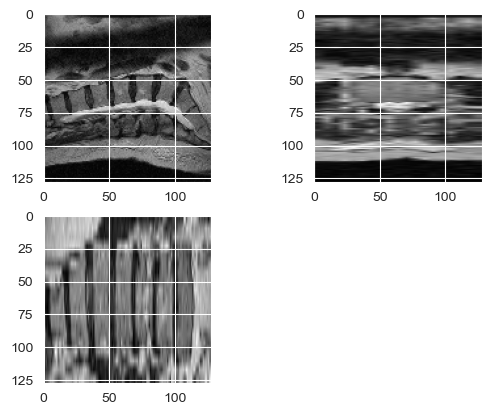

In [50]:
show_mid_slices(testset_5[0][0][0])


/opt/homebrew/Caskroom/miniconda/base/envs/pythonProject/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(


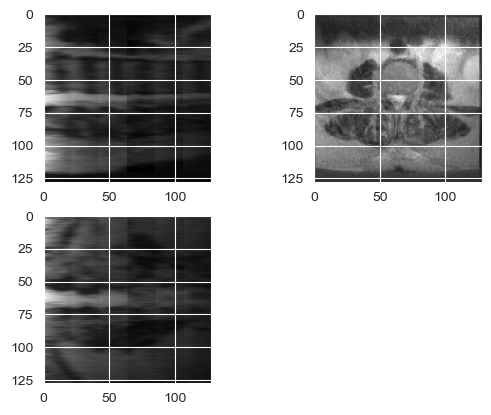

In [64]:
show_mid_slices(np.rot90(np.rot90(testset_5[0][0][1], axes=(1,2)), axes=(2,0)))


/opt/homebrew/Caskroom/miniconda/base/envs/pythonProject/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(


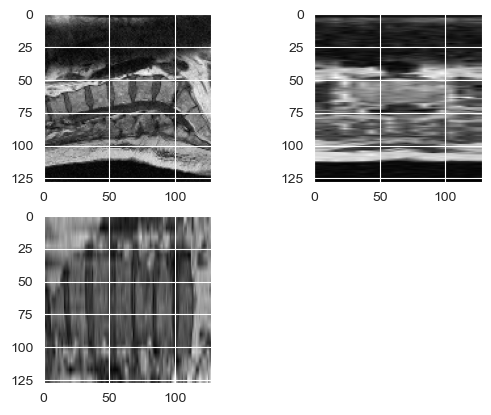

In [52]:
show_mid_slices(testset_5[0][0][2])


In [ ]:
import torchio as tio

foo = tio.ScalarImage("/Users/victorsahin/PycharmProjects/pythonProject/data/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845")
foo=transform_3d(foo)
foo.plot()

In [ ]:
foo.spacing

In [ ]:
foo2 = tio.ScalarImage("/Users/victorsahin/PycharmProjects/pythonProject/data/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3481971518",
                     spacing=6)
foo2.plot()

In [ ]:
import glob
import pydicom
import os
import torch
import cv2
import numpy as np

def load_dicom_series(path, transform=None):
    def get_affine_matrix(dicom_slice):
        return np.array([
            [dicom_slice.ImageOrientationPatient[0], dicom_slice.ImageOrientationPatient[3], 0, dicom_slice.ImagePositionPatient[0]],
            [dicom_slice.ImageOrientationPatient[1], dicom_slice.ImageOrientationPatient[4], 0, dicom_slice.ImagePositionPatient[1]],
            [dicom_slice.ImageOrientationPatient[2], dicom_slice.ImageOrientationPatient[5], 0, dicom_slice.ImagePositionPatient[2]],
            [0,0,0,1]
        ])
    files = glob.glob(os.path.join(path, '*.dcm'))
    files = sorted(files, key=lambda x: int(x.split('/')[-1].split("\\")[-1].split('.')[0]))
    slices = [pydicom.dcmread(fname) for fname in files]

    
    
    return tio.ScalarImage(path, affine=get_affine_matrix(slices[0]))

foo = load_dicom_series("/Users/victorsahin/PycharmProjects/pythonProject/data/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845")
foo.plot()

In [ ]:
foo.spacing

In [ ]:
load_dicom_series("/Users/victorsahin/PycharmProjects/pythonProject/data/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3481971518")\
.plot()

In [ ]:
bar = tio.Subject("/Users/victorsahin/PycharmProjects/pythonProject/data/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939")